In [4]:
# couette flow - varying porosity

import numpy as np
import time
import matplotlib.pyplot as plt

start = time.time()

# Simulation parameters
nx = 80
ny = 80

tau = 0.8
omega = 1/tau # omega = dt/tau but dt = 1 for simplicity
cssq = 1/3
nu = cssq*(tau - 0.5)

tol = 1e-6 # tolerance
relerror = 1

eps = np.zeros((nx, ny))
eps[:, :ny//2] = 0.1
eps[:, ny//2:] = 1.0

H = ny + 0.5
Da = np.zeros((nx, ny))
Da[:, :ny//2] = 0.001
Da[:, ny//2:] = 1e6
Re = 0.01

umax = Re*nu/H
K = Da*H**2
Feps = 1.75/np.sqrt(150*eps**3)

c0 = 0.5*(1 + eps*0.5*nu/K)
c1 = eps*0.5*Feps/(K**0.5)

# D2Q9 lattice arrangement
ndir = 9
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])

# Simulation initialisation
rho = np.ones((nx, ny))

ux = np.zeros((nx, ny))
ux[:, ny - 1] = umax
uy = np.zeros((nx, ny))
uxold = ux.copy()
uyold = np.zeros((nx, ny))
feq = np.zeros((ndir, nx, ny))
Fdist = np.zeros((ndir,nx,ny))

Gx = 0
umagn = np.sqrt(ux**2 + uy**2)
Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)
for k in range(ndir):
    dotprod = cx[k]*ux + cy[k]*uy
    udotu = ux**2 + uy**2
    dotprodF = cx[k]*Fx + cy[k]*Fy
    udotF = ux*Fx + uy*Fy

    feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

    Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))

f = np.copy(feq)
fold = np.copy(feq)

t = 0

print('Starting simulation')

# Simulation loop
while relerror > tol and t < 200000:

    # Collision
    f = (1 - omega)*fold + omega*feq + Fdist

    # Streaming
    # automatically applies periodic boundary conditions in all edges of computation domain
    for k in range(ndir):
        fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

    # Boundary conditions
    fold[3, :, 0] = f[4, :, 0]
    fold[5, :, 0] = f[7, :, 0]
    fold[6, :, 0] = f[8, :, 0]

    # Zou & He boundary conditions
    rhon = fold[0, :, ny - 1] + fold[1, :, ny - 1] + fold[2, :, ny - 1] + 2*fold[3, :, ny - 1] + 2*fold[5, :, ny - 1] + 2*fold[6, :, ny - 1]

    rhou = rhon*umax

    fold[4, :, ny - 1] = f[3, :, ny - 1]
    fold[7, :, ny - 1] = f[5, :, ny - 1] + 0.5*(f[1, :, ny - 1] - f[2, :, ny - 1]) - 0.5*rhou
    fold[8, :, ny - 1] = f[6, :, ny - 1] - 0.5*(f[1, :, ny - 1] - f[2, :, ny - 1]) + 0.5*rhou

    # Macroscopic variables
    rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]

    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny))


    for k in range(ndir):
        vx += cx[k]*fold[k, :, :]
        vy += cy[k]*fold[k, :, :]

    vx = vx/rho
    vy /= rho
    vmagn = np.sqrt(vx**2 + vy**2)

    ux = vx / (c0 + np.sqrt(c0**2 + c1*vmagn))
    uy = vy / (c0 + np.sqrt(c0**2 + c1*vmagn))
    umagn = np.sqrt(ux**2 + uy**2)

    Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
    Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)


    # Equilibrium distribution function (+ force term)
    for k in range(ndir):
        dotprod = cx[k]*ux + cy[k]*uy
        udotu = ux**2 + uy**2
        dotprodF = cx[k]*Fx + cy[k]*Fy
        udotF = ux*Fx + uy*Fy

        feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

        Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))


    # Computing relative error
    if t>5000:
        num = np.sqrt((ux - uxold)**2 + (uy - uyold)**2)/umagn

        relerror = np.max(num)

    uxold = ux
    uyold = uy

    t += 1

    if t % 1000 == 0:
        print(t, time.time()-start, relerror)
    # if t % 5000 == 0:
    #     plt.imshow(umagn/umax)
    #     plt.colorbar()
    #     plt.show()

print(t, relerror, umax, np.max(ux))

Starting simulation
1000 2.762977123260498 1
2000 5.493658781051636 1
3000 10.004552364349365 1
4000 15.560970544815063 1
5000 18.987278938293457 1
6000 23.529099225997925 0.00015260202989070108
7000 29.419233083724976 9.007546110790747e-05
8000 33.16823124885559 5.5107226806159e-05
9000 37.52026867866516 3.4516678153950136e-05
10000 43.96875524520874 2.1950465711864345e-05
11000 48.08737254142761 1.4087350881958282e-05
12000 52.534806966781616 9.093252857749042e-06
13000 58.96380615234375 5.932137280274174e-06
14000 64.62173008918762 3.821642634175002e-06
15000 73.28865694999695 2.49781575065389e-06
16000 77.5035753250122 1.6367681612365318e-06
17000 81.84779715538025 1.063842646820986e-06
17139 9.987748095202428e-07 1.2422360248447205e-05 1.2378916138214811e-05


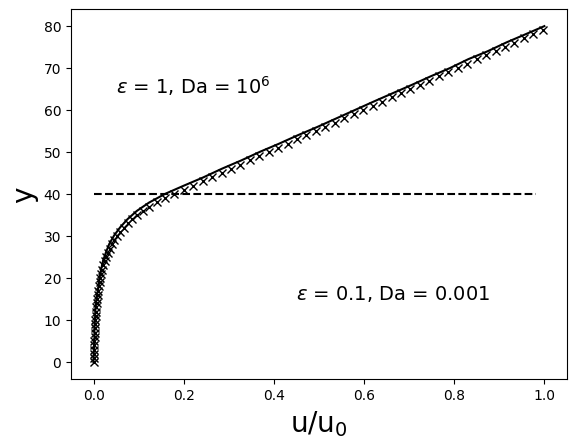

In [5]:
# Post-processing

x = np.arange(0, ny)
y = umagn[nx//2, :]/umax
plt.plot(y, x, 'kx', label = 'numerical')

xy0 = np.array((-0.00042669, 0.00026098, 0.00026438, 0.025283, 0.00095545, 0.050723, 0.0019921, 0.076163, 0.0016465, 0.10035, 0.0030287, 0.12662, 0.0037197, 0.15123, 0.0054474, 0.17625, 0.0078661, 0.20169,
               0.010976, 0.22630, 0.013049, 0.25174, 0.016850, 0.27718, 0.020996, 0.30178, 0.027216, 0.32597, 0.034818, 0.35183, 0.045529, 0.37685, 0.058660, 0.40063,
               0.075245, 0.42524, 0.095977, 0.44984, 0.12293, 0.47445, 0.15852, 0.50032, 0.20033, 0.52493, 0.24283, 0.54912, 0.28498, 0.57540, 0.32714, 0.59960,
               0.36895, 0.62546, 0.41007, 0.64882, 0.45291, 0.67468, 0.49611, 0.69929, 0.53688, 0.72390, 0.57973, 0.74977, 0.62119, 0.77480, 0.66369, 0.79982,
               0.70585, 0.82444, 0.74765, 0.84988, 0.79050, 0.87449, 0.83162, 0.90119, 0.87343, 0.92413, 0.91593, 0.95083, 0.95739, 0.97461, 0.99989, 0.99922))
x0 = xy0[::2]
y0 = xy0[1::2]*80
plt.plot(x0, y0,'k-', label = 'reference')


# print(umax)
yH = [40 for x0 in x]
plt.plot(x/H, yH, 'k--')
plt.text(0.05, 64, '$\epsilon$ = 1, Da = $\mathregular{10^{6}}$', fontsize = 14, color = 'k')
plt.text(0.45, 15, '$\epsilon$ = 0.1, Da = 0.001', fontsize = 14, color = 'k')
plt.ylabel('y', fontsize = 20)
plt.xlabel('$\mathregular{u/u_0}$', fontsize = 20)
plt.show()

Starting simulation for Da = 1e-05
1000 6.666845321655273 1
2000 10.513734579086304 1
3000 12.98836374282837 1
4000 15.440711975097656 1
5000 18.06931447982788 1
6000 21.204323291778564 1
7000 24.449981212615967 1
8000 27.00485587120056 1
9000 29.482471466064453 1
10000 31.99224591255188 1


<ipython-input-7-bcbb1f466664>:136: RuntimeWarning: divide by zero encountered in divide
  num = ((ux - uxold)**2 + (uy - uyold)**2)**0.5/umagn


11000 35.06589937210083 2.3333333333333335
12000 38.64282751083374 2.3333333333333335
13000 41.24923276901245 2.3333333333333335
14000 43.80684232711792 2.3333333333333335
15000 46.68803119659424 2.3333333333333335
16000 49.571916580200195 2.3333333333333335
17000 53.13421988487244 2.3333333333333335
18000 55.70528841018677 2.3333333333333335
19000 58.30565667152405 2.3333333333333335
20000 60.836243629455566 2.3333333333333335
21000 63.557395458221436 2.3333333333333335
22000 67.13609433174133 2.3333333333333335
23000 69.94081544876099 2.3333333333333335
24000 72.57975649833679 2.3333333333333335
25000 75.2328929901123 2.3333333333333335
26000 77.88453316688538 2.3333333333333335
27000 81.58397936820984 2.3333333333333335
28000 84.37756276130676 2.3333333333333335
29000 86.94656825065613 2.3333333333333335
30000 89.51161551475525 2.3333333333333335
30000 2.3333333333333335 0.012422360248447204 0.010117842731860444
1.2445666311461337e-14
Starting simulation for Da = 0.001
1000 2.450872

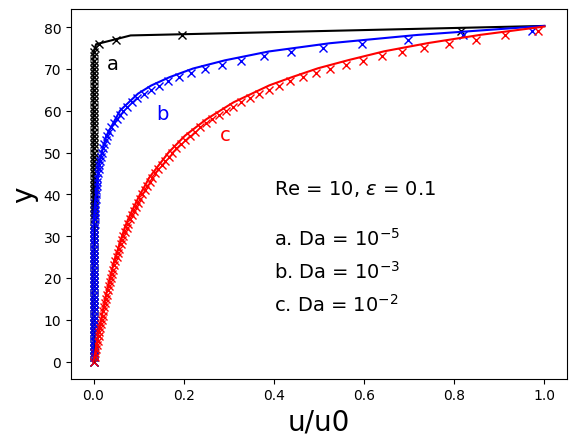

In [7]:
  # couette flow - change darcy number

import numpy as np
import time
import matplotlib.pyplot as plt


Darcy = [1e-5, 1e-3, 1e-2]
y = []
for Da in Darcy:

    start = time.time()

    # Simulation parameters
    nx = 80
    ny = 80

    tau = 0.8
    omega = 1/tau
    cssq = 1/3
    nu = cssq*(tau - 0.5)

    tol = 1e-6
    relerror = 1

    eps = 0.1
    Re = 10

    H = ny + 0.5
    umax = Re*nu/H
    K = Da*H**2
    Feps = 1.75/(150*eps**3)**0.5

    c0 = 0.5*(1 + eps*0.5*nu/K)
    c1 = eps*0.5*Feps/(K**0.5)

    # D2Q9 lattice arrangement
    ndir = 9
    w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
    cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
    cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])

    # Simulation initialisation
    rho = np.ones((nx, ny))

    ux = np.zeros((nx, ny))
    ux[:, ny - 1] = umax
    uy = np.zeros((nx, ny))
    uxold = ux.copy()
    uyold = np.zeros((nx, ny))
    feq = np.zeros((ndir, nx, ny))
    Fdist = np.zeros((ndir,nx,ny))

    Gx = 0
    umagn = np.sqrt(ux**2 + uy**2)
    Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
    Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

    for k in range(ndir):
        dotprod = cx[k]*ux + cy[k]*uy
        udotu = ux**2 + uy**2
        dotprodF = cx[k]*Fx + cy[k]*Fy
        udotF = ux*Fx + uy*Fy

        feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

        Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))

    f = np.copy(feq)
    fold = np.copy(feq)

    t = 0

    print('Starting simulation for Da =', Da)

    # Simulation loop
    while relerror > tol and t < 30000:

        # Collision
        f = (1 - omega)*fold + omega*feq + Fdist

        # Streaming
        # automatically applies periodic boundary conditions in all edges of computation domain
        for k in range(ndir):
            fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

        # Boundary conditions
        fold[3, :, 0] = f[4, :, 0]
        fold[5, :, 0] = f[7, :, 0]
        fold[6, :, 0] = f[8, :, 0]


        rhon = fold[0, :, ny - 1] + fold[1, :, ny - 1] + fold[2, :, ny - 1] + 2*fold[3, :, ny - 1] + 2*fold[5, :, ny - 1] + 2*fold[6, :, ny - 1]

        rhou = rhon*umax

        fold[4, :, ny - 1] = f[3, :, ny - 1]
        fold[7, :, ny - 1] = f[5, :, ny - 1] + 0.5*(f[1, :, ny - 1] - f[2, :, ny - 1]) - 0.5*rhou
        fold[8, :, ny - 1] = f[6, :, ny - 1] - 0.5*(f[1, :, ny - 1] - f[2, :, ny - 1]) + 0.5*rhou


        # Macroscopic variables: density, velocity, forces
        rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]
        vx = np.zeros((nx, ny))
        vy = np.zeros((nx, ny))


        for k in range(ndir):
            vx += cx[k]*fold[k, :, :]
            vy += cy[k]*fold[k, :, :]

        vx = vx/rho + 0.5*eps*Gx
        vy /= rho
        vmagn = (vx**2 + vy**2)**0.5

        ux = vx / (c0 + (c0**2 + c1*vmagn)**0.5)
        uy = vy / (c0 + (c0**2 + c1*vmagn)**0.5)
        umagn = (ux**2 + uy**2)**0.5

        Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
        Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

        # Equilibrium distribution function (+ force term)
        for k in range(ndir):
            dotprod = cx[k]*ux + cy[k]*uy
            udotu = ux**2 + uy**2
            dotprodF = cx[k]*Fx + cy[k]*Fy
            udotF = ux*Fx + uy*Fy
            feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

            Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))


        # Computing relative error
        if t > 10000:
            num = ((ux - uxold)**2 + (uy - uyold)**2)**0.5/umagn
            relerror = np.max(num)

        uxold = ux
        uyold = uy

        t += 1

        if t % 1000 == 0:
            print(t, time.time()-start, relerror)

    print(t, relerror, umax, np.max(ux))

    umagn = np.sqrt(ux**2 + uy**2)

    y.append(umagn[nx // 2, :]/umax)

    print(umagn[nx//2, ny//2]/umax)

x = range(0, ny)
xy0 = np.array((0.0012891, -0.0011192, -0.00018416, 0.098175, -0.00018416, 0.19935, -0.00018416, 0.29864, 0.0012891, 0.39982, -0.00018416, 0.45040, -0.00018416, 0.47476, -0.00018416, 0.49911, -0.00018416, 0.52347,
                -0.00018416, 0.59841, -0.00018416, 0.69958, -0.00018416, 0.79888, -0.00018416, 0.90005, -0.00018416, 0.92440, 0.0057090, 0.94877, 0.082320, 0.97518, 1.0002, 1.0036))
x0 = xy0[::2]
y0 = xy0[1::2]*80
xy1 = np.array((-0.00018416, -0.0011227, -0.00018416, 0.10005, -0.00018416, 0.19935, -0.00018416, 0.29864, -0.00018416, 0.39981, 0.0027624, 0.47289, 0.0057090, 0.49913, 0.0071823, 0.52348, 0.013076, 0.59844,
                0.027808, 0.67342, 0.058748, 0.75030, 0.098527, 0.80098, 0.12799, 0.82541, 0.16777, 0.84986, 0.22081, 0.87621, 0.29153, 0.90073, 0.38877, 0.92719, 0.52431, 0.95186, 0.71878, 0.97667, 1.0002, 1.0036))
x1 = xy1[::2]
y1 = xy1[1::2]*80
xy2 = np.array((-0.00018416, -0.0011227, 0.013076, 0.098206, 0.027808, 0.19941, 0.045488, 0.29875, 0.069061, 0.39998, 0.076427, 0.42435, 0.085267, 0.45060, 0.094107, 0.47498, 0.10295, 0.49935,
                0.11326, 0.52373, 0.12357, 0.54999, 0.16630, 0.62503, 0.20313, 0.67570, 0.25028, 0.72452, 0.31068, 0.77525, 0.39024, 0.82602, 0.44033, 0.85049, 0.49779, 0.87686, 0.56556, 0.90137, 0.64512, 0.92779, 0.74236, 0.95237, 0.85875, 0.97700, 1.0002, 1.0017))

x2 = xy2[::2]
y2 = xy2[1::2]*80
plt.plot(y[0], x, 'kx', label = "Da=1e-5")
plt.plot(y[1], x, 'bx', label = "Da=1e-3")
plt.plot(y[2], x, 'rx', label = "Da=1e-2")
plt.plot(x0, y0, 'k-', label = "Da=1e-5 (ref)")
plt.plot(x1, y1, 'b-', label = "Da=1e-3 (ref)")
plt.plot(x2, y2, 'r-', label = "Da=1e-2 (ref)")
plt.text(0.4, 40, 'Re = 10, $\epsilon$ = 0.1', fontsize = 14)
plt.text(0.4, 28, 'a. Da = $\mathregular{10^{-5}}$', fontsize = 14)
plt.text(0.4, 20, 'b. Da = $\mathregular{10^{-3}}$', fontsize = 14)
plt.text(0.4, 12, 'c. Da = $\mathregular{10^{-2}}$', fontsize = 14)
plt.text(0.03, 70, 'a', fontsize = 14, color = 'k')
plt.text(0.14, 58, 'b', fontsize = 14, color = 'b')
plt.text(0.28, 53, 'c', fontsize = 14, color = 'r')
plt.ylabel('y', fontsize = 20)
plt.xlabel('u/u0', fontsize = 20)

plt.show()

Starting simulation for Re = 0.001
1000 3.5237603187561035 1
2000 6.152691125869751 1
3000 8.573028087615967 1
4000 10.980996370315552 1
5000 13.397743225097656 1
6000 16.80758833885193 0.0002776446462011775
7000 19.926584720611572 0.00018112172600893612
8000 22.53586769104004 0.00012197357121578865
9000 25.577369689941406 8.397023686523463e-05
10000 29.228922843933105 5.877114034494533e-05
11000 32.83558392524719 4.1618698849159884e-05
12000 35.518242835998535 2.9770895274910743e-05
13000 38.09725546836853 2.1412889260886367e-05
14000 40.67312574386597 1.5455069651521262e-05
15000 43.18847370147705 1.1233323063453089e-05
16000 46.780534505844116 8.155215739159558e-06
17000 49.64519739151001 5.965531696127919e-06
18000 52.22032952308655 4.361294682224729e-06
19000 54.79141020774841 3.173793806928535e-06
20000 57.374018907547 2.325992706537559e-06
21000 60.79555535316467 1.7229173858414723e-06
22000 63.88638639450073 1.2964417139500557e-06
22909 9.76943715664428e-07 1.2422360248447205e-

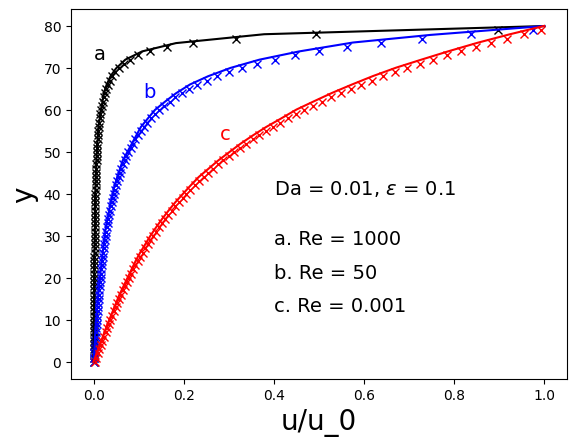

In [8]:
# couette flow - change reynolds number

import numpy as np
import time
import matplotlib.pyplot as plt

Reyn = [0.001, 50, 1000]
y = []

for Re in Reyn:
    start = time.time()

    # Simulation parameters
    nx = 80
    ny = 80

    tau = 0.8
    omega = 1/tau
    cssq = 1/3
    nu = cssq*(tau - 0.5)

    tol = 1e-6
    relerror = 1

    eps = 0.1
    Da = 1e-2

    H = ny + 0.5
    umax = Re*nu/H
    K = Da*H**2
    Feps = 1.75/(150*eps**3)**0.5

    c0 = 0.5*(1 + eps*0.5*nu/K)
    c1 = eps*0.5*Feps/(K**0.5)

    # D2Q9 lattice arrangement
    ndir = 9
    w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
    cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
    cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])

    # Simulation initialisation
    rho = np.ones((nx, ny))

    ux = np.zeros((nx, ny))
    ux[:, ny - 1] = umax
    uy = np.zeros((nx, ny))
    uxold = np.zeros((nx, ny))
    uyold = np.zeros((nx, ny))
    feq = np.zeros((ndir, nx, ny))
    Fdist = np.zeros((ndir,nx,ny))

    Gx = 0
    umagn = np.sqrt(ux**2 + uy**2)
    Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
    Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

    for k in range(ndir):
        dotprod = cx[k]*ux + cy[k]*uyold
        udotu = ux**2 + uy**2
        dotprodF = cx[k]*Fx + cy[k]*Fy
        udotF = ux*Fx + uy*Fy

        feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

        Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))

    f = np.copy(feq)
    fold = np.copy(feq)

    t = 0

    print('Starting simulation for Re =', Re)

    # Simulation loop
    while relerror > tol and t < 200000:

        # Collision
        f = (1 - omega)*fold + omega*feq + Fdist

        # Streaming
        # automatically applies periodic boundary conditions in all edges of computation domain
        for k in range(ndir):
            fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

        # Boundary conditions
        fold[3, :, 0] = f[4, :, 0]
        fold[5, :, 0] = f[7, :, 0]
        fold[6, :, 0] = f[8, :, 0]

        rhon = fold[0, :, ny - 1] + fold[1, :, ny - 1] + fold[2, :, ny - 1] + 2*fold[3, :, ny - 1] + 2*fold[5, :, ny - 1] + 2*fold[6, :, ny - 1]
        rhou = rhon*umax

        fold[4, :, ny - 1] = f[3, :, ny - 1]
        fold[7, :, ny - 1] = f[5, :, ny - 1] + 0.5*(f[1, :, ny - 1] - f[2, :, ny - 1]) - 0.5*rhou
        fold[8, :, ny - 1] = f[6, :, ny - 1] - 0.5*(f[1, :, ny - 1] - f[2, :, ny - 1]) + 0.5*rhou


        # Macroscopic variables: density, velocity, forces
        rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]
        vx = np.zeros((nx, ny))
        vy = np.zeros((nx, ny))


        for k in range(ndir):
            vx += cx[k]*fold[k, :, :]
            vy += cy[k]*fold[k, :, :]

        vx = vx/rho + 0.5*eps*Gx
        vy /= rho
        vmagn = (vx**2 + vy**2)**0.5

        ux = vx / (c0 + (c0**2 + c1*vmagn)**0.5)
        uy = vy / (c0 + (c0**2 + c1*vmagn)**0.5)
        umagn = (ux**2 + uy**2)**0.5

        Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
        Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

        # Equilibrium distribution function (+ force term)
        for k in range(ndir):
            dotprod = cx[k]*ux + cy[k]*uy
            udotu = ux**2 + uy**2
            dotprodF = cx[k]*Fx + cy[k]*Fy
            udotF = ux*Fx + uy*Fy
            feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

            Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))


        # Computing relative error
        if t > 5000:
            num = ((ux - uxold)**2 + (uy - uyold)**2)**0.5/umagn
            relerror = np.max(num)

        uxold = ux
        uyold = uy

        t += 1

        if t % 1000 == 0:
            print(t, time.time()-start, relerror)

    print(t, relerror, umax, np.max(ux))

    umagn = np.sqrt(ux**2 + uy**2)

    y.append(umagn[nx//2, :]/umax)

    print(umagn[nx//2, ny//2]/umax)

x = range(0, ny)
xy0 = np.array((-0.00049595, -0.00012246, -0.00045462, 0.098393, 0.0010835, 0.19880, 0.0011256, 0.29921, 0.0026629, 0.39773, 0.0026844, 0.44888, 0.0026947, 0.47351, 0.0033828, 0.49926,
                0.0039730, 0.52386, 0.0042735, 0.54919, 0.0057391, 0.59855, 0.010269, 0.69895, 0.022279, 0.79936, 0.028274, 0.82399, 0.037261, 0.85051, 0.049238, 0.87324,
                0.070193, 0.89976, 0.10760, 0.92438, 0.18241, 0.94899, 0.37840, 0.97546, 1.0007, 0.99992))
x0 = xy0[::2]
y0 = xy0[1::2]*80
xy1 = np.array((-0.00049595, -0.00012246, 0.0040333, 0.098392, 0.010059, 0.19880, 0.017581, 0.29921, 0.026600, 0.39961, 0.034100, 0.44887, 0.037102, 0.47350, 0.041601, 0.49813, 0.046100, 0.52465,
                0.052094, 0.54928, 0.064083, 0.59853, 0.10452, 0.69893, 0.11949, 0.72355, 0.13595, 0.75007, 0.15840, 0.77470, 0.18235, 0.79932, 0.21378, 0.82583, 0.25418, 0.85045, 0.30356, 0.87507, 0.36790, 0.89968,
                0.45617, 0.92428, 0.57586, 0.95078, 0.74791, 0.97346, 1.0007, 0.99992))
x1 = xy1[::2]
y1 = xy1[1::2]*80
xy2 = np.array((-0.00067562, -0.00051623, 0.026813, 0.099252, 0.056869, 0.19927, 0.092651, 0.29928, 0.10273, 0.32429, 0.11439, 0.34979, 0.12526, 0.37404, 0.13831, 0.40005,
                0.15135, 0.42455, 0.16558, 0.44930, 0.18099, 0.47481, 0.19739, 0.49906, 0.21458, 0.52431, 0.23315, 0.55031, 0.25389, 0.57381, 0.27602, 0.59906, 0.30032, 0.62356, 0.32560, 0.64906,
                0.35306, 0.67381, 0.38269, 0.69906, 0.41548, 0.72406, 0.45004, 0.75105, 0.48797, 0.77505, 0.52846, 0.80029, 0.57270, 0.82529, 0.61990, 0.85078, 0.67125, 0.87578,
                0.72695, 0.89952, 0.78777, 0.92476, 0.85295, 0.95025, 0.92305, 0.97498, 1.0003, 1.0002))
x2 = xy2[::2]
y2 = xy2[1::2]*80
plt.plot(y[2], x, 'kx', label = "Re=1000")
plt.plot(y[1], x, 'bx', label = "Re=50")
plt.plot(y[0], x, 'rx', label = "Re=0.001")
plt.plot(x0, y0, 'k-', label = "Re=1000 (ref)")
plt.plot(x1, y1, 'b-', label = "Re=50 (ref)")
plt.plot(x2, y2, 'r-', label = "Re=0.001 (ref)")
plt.text(0.4, 40, 'Da = 0.01, $\epsilon$ = 0.1', fontsize = 14)
plt.text(0.4, 28, 'a. Re = 1000', fontsize = 14)
plt.text(0.4, 20, 'b. Re = 50', fontsize = 14)
plt.text(0.4, 12, 'c. Re = 0.001', fontsize = 14)
plt.text(0, 72, 'a', fontsize = 14, color = 'k')
plt.text(0.11, 63, 'b', fontsize = 14, color = 'b')
plt.text(0.28, 53, 'c', fontsize = 14, color = 'r')
plt.ylabel('y', fontsize = 20)
plt.xlabel('u/u_0', fontsize = 20)
plt.show()
